# VAD

## Abstract

## Introduction

## Method

### Dataset

All audio files were associated with a label file of the same name.
1. Volume
    1. 1914 files
       1. 957 .wav audio
       2. 957 .json abels

### Technical setup

In [231]:
# Move to project path
import os
os.chdir(context.project_path)

# import dependencies
import os
import scipy
import glob
import time
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# ignore warnings for esthetics
import warnings
warnings.filterwarnings('ignore')

In [232]:
# parameters
VERBOSE = True

### Model implementation

#### System description

#### Neural network architecture

##### Input

##### GRU layer

##### Dense layer

#### Batch inference

## Experiments

### Experimental setup

## Results

### Several speakers

Listening to a sample of the audio files revealed that a variety of speakers

- Humans
    - men
    - women
- Synthetic
    - men
    - women

I also characterised speeches by their variety of amplitudes and pace
- Normal vs fast pace  
- Loud vs, low volume

### Speech signal description

We show below the best typical example of an audio signal (top panel). and its associated speech labels "1" for speech and "0" for no speech (bottom panel).

All audio signals were 32 bits float single channel time series. We run a few sanity checks:

In [233]:
# load all data
data_path = "data/01_raw/vad_data/"
audio_files = glob.glob(f"{data_path}*.wav")
audio_files.sort()
label_files = glob.glob(f"{data_path}*.json")
label_files.sort()

In [234]:
# run sanity test on file-label name mapping and sorting
correct_mapping = []
for aud, lbl  in zip(audio_files, label_files):
    correct_mapping.append(os.path.splitext(aud)[0] == os.path.splitext(lbl)[0])
print(f"- the {sum(correct_mapping)} label files were correctly mapped with the {len(audio_files)} audio files")

- the 957 label files were correctly mapped with the 957 audio files


Speaker information:

In [235]:
# get speaker info
file_speaker = [os.path.basename(file).split("-")[0] for file in audio_files]
speaker_set = np.unique(file_speakers)
print("- Number:", len(speaker_set), "speakers")
print("- Speakers'ID:", speaker_set)

- Number: 34 speakers
- Speakers'ID: ['103' '1034' '1040' '1069' '1081' '1088' '1098' '1116' '118' '1183'
 '1235' '1246' '125' '1263' '1334' '1355' '1363' '1447' '1455' '150'
 '1502' '1553' '1578' '1594' '1624' '163' '1723' '1737' '1743' '1841'
 '1867' '1898' '19' '1926']


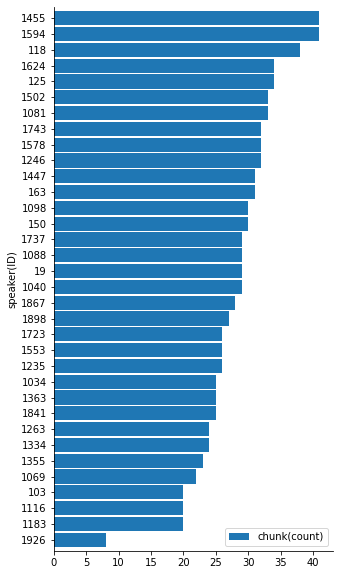

In [236]:
# get number of chunks per speaker
speaker, nb_chunks = zip(*Counter(file_speaker).items())
counts = pd.DataFrame(data=(speaker, nb_chunks), index=["speaker(ID)", "chunk(count)"]).T
counts.sort_values(by="chunk(count)").plot.barh(x="speaker(ID)", figsize=(5, 10), width=0.9);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [237]:
# define a few useful functions
def get_snr(audio, label):
    return 20*np.log10(S_rms / N_rms)

def read_X(audio_path):
    sample_rate, data = scipy.io.wavfile.read(
        audio_path
    )
    sample_size = len(data)
    time_unit = 1 / sample_rate
    duration_in_sec = time_unit * len(data)
    timestamp = np.arange(0, len(data), 1) * time_unit
    return {
        "audio": {
            "data": data.reshape(sample_size, 1),
            "metadata": {
                "sample_rate": sample_rate,
                "sample_size": sample_size,
                "time_unit": time_unit,
                "duration_in_sec": duration_in_sec,
                "timestamp": timestamp,
            },
        }
    }
    
def load_Y(label_path):
    return pd.read_json(label_path)    

def sync_audio_and_labels(audio, label):

    # get data
    data = audio["audio"]["data"]
    time_unit = audio["audio"]["metadata"]["time_unit"]
    sample_size = audio["audio"]["metadata"]["sample_size"]

    # create timestamps
    audio["audio"]["metadata"]["timestamp"] = np.arange(0, len(data), 1) * time_unit

    # case label exists
    # synchronize labels with audio
    synced_label = np.zeros((sample_size, 1))
    array = label.values
    for ix in range(array.shape[0]):
        interval = array[ix][0]
        speech_start = interval["start_time"]
        speech_end = interval["end_time"]
        span = np.where(
            np.logical_and(
                audio["audio"]["metadata"]["timestamp"] >= speech_start,
                audio["audio"]["metadata"]["timestamp"] <= speech_end,
            )
        )
        synced_label[span] = 1
    audio["label"] = synced_label
    return audio

def plot_labelled_audio(timestamp, audio, labels, n_sample):
    # plot audio
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,5))
    ax1.plot(timestamp, audio[:n_sample], "r-")

    # plot label
    ax2.plot(timestamp, labels[:n_sample], "b-")
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    
    return f, ax1, ax2

We show below a few interesting example chunks for 7 different speakers (numbered panels).
- All visualized audio were very well labelled (see supplementary).

SPEAKER 19 - PANEL 0
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


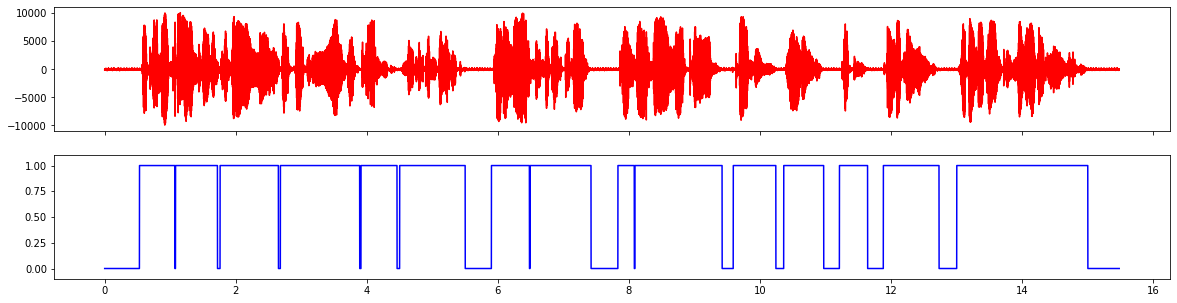

SPEAKER 1553 - PANEL 1
  data/01_raw/vad_data/1553-140048-0009.wav
  data/01_raw/vad_data/1553-140048-0009.json


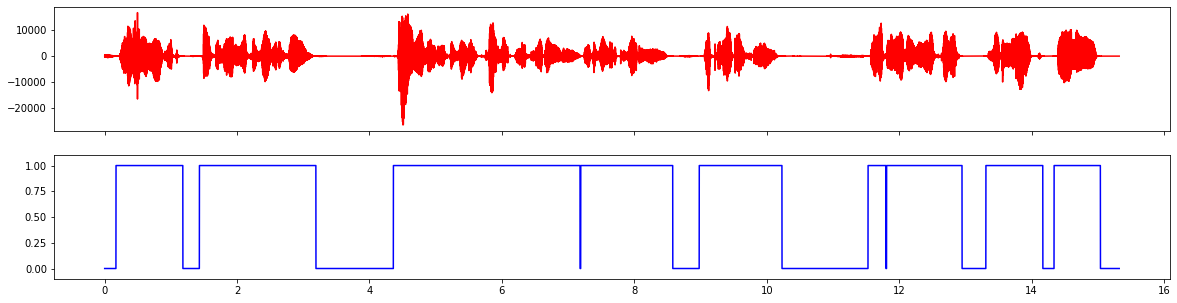

SPEAKER 103 - PANEL 2
  data/01_raw/vad_data/103-1241-0027.wav
  data/01_raw/vad_data/103-1241-0027.json


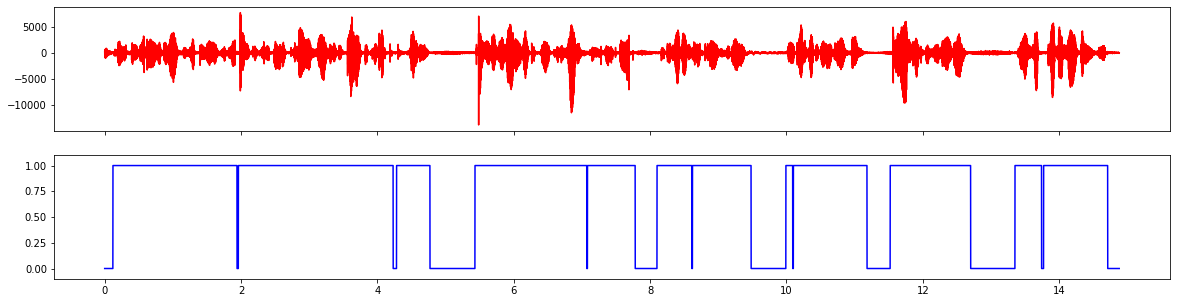

SPEAKER 1034 - PANEL 3
  data/01_raw/vad_data/1034-121119-0047.wav
  data/01_raw/vad_data/1034-121119-0047.json


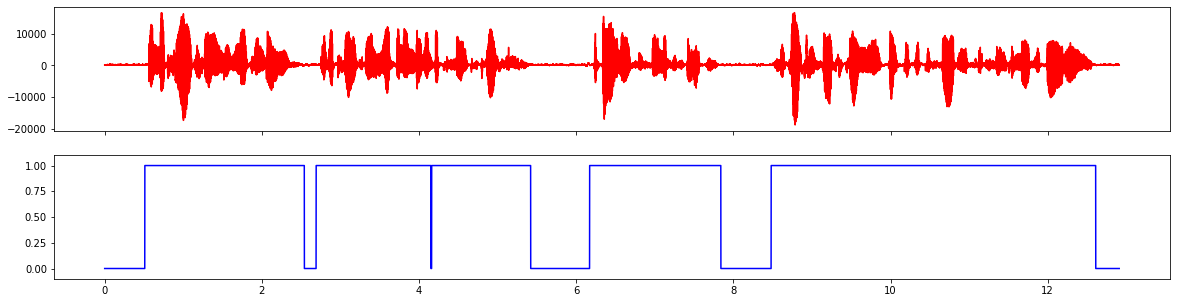

2.06 sec


In [238]:
# show an example per speaker
exple_pos = [920, 605, 17, 31]

# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " ,audio_files[exple])
    print(" " ,label_files[exple])    
    audio = read_X(audio_files[exple])
    label = load_Y(label_files[exple])
    synced = sync_audio_and_labels(audio, label)
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )
if VERBOSE: 
    print(np.round(time.time()-tic,2), "sec")

We validated that all audio files were associated with a .json label file.


In [239]:
# data quality check
print("- audio file sample size:", len(audio_files))
print("- label file sample size:", len(label_files))

- audio file sample size: 957
- label file sample size: 957


The entire sample could be quickly loaded:

In [240]:
# loading
tic = time.time()
audio_data = [scipy.io.wavfile.read(audio) for audio in audio_files]
print("- loading duration:", np.round(time.time()-tic,2), "sec")

- loading duration: 2.36 sec


Sample size and sampling rate:

In [241]:
# get sample rate per audio
sample_rates = [audio for audio in np.array(audio_data)[:,0]]
sample_rate = np.unique(sample_rates)
print("Sample rate information:")
print("-", len(sample_rate), "sample rate(s)")
print("- rate:", np.unique(sample_rates)[0], "Hz")

Sample rate information:
- 1 sample rate(s)
- rate: 16000 Hz


We kept the signal at 16Khz which is enough to cover the frequency range of human speech according to the literature (Human voice b/w `85hz to 8khz` [REF], hearing b/w `20 hz to 20kh`[REF]).

In [242]:
# get sample size per audio
sample_sizes = [len(audio) for audio in np.array(audio_data)[:,1]]
print("Sample size information:")
print("-", len(np.unique(sample_sizes)), "sample size(s)")
print("- max:", max(sample_sizes), "samples (", max(sample_sizes)/sample_rate, "secs)")
print("- min:", min(sample_sizes), "samples (", min(sample_sizes)/sample_rate, "secs)")
print("- median:", np.median(sample_sizes), "samples (", np.median(sample_sizes)/sample_rate, "secs)")

Sample size information:
- 711 sample size(s)
- max: 275280 samples ( [17.205] secs)
- min: 22560 samples ( [1.41] secs)
- median: 222080.0 samples ( [13.88] secs)


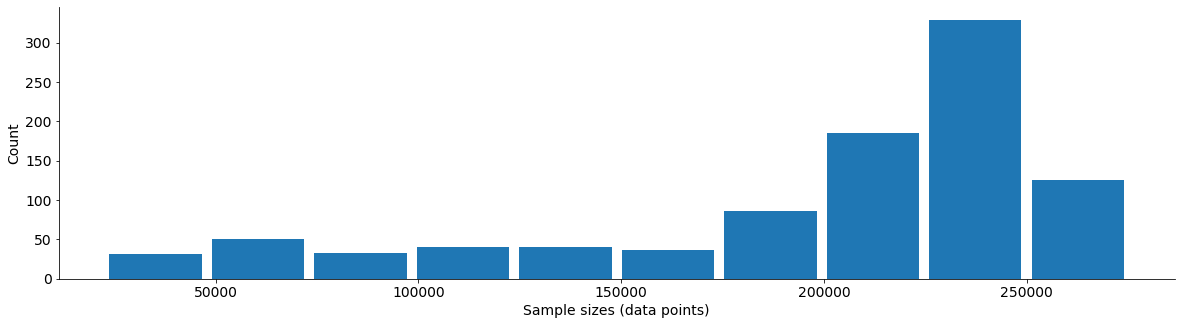

In [243]:
# sample size distribution
fig = plt.figure(figsize=(20,5))
plt.hist(sample_sizes, rwidth=0.9);
plt.xlabel("Sample sizes (data points)", fontsize=14);
plt.ylabel("Count", fontsize=14);
plt.xticks(fontsize=14); 
plt.yticks(fontsize=14);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

**Signal amplitudes**: the true decibel amplitude of the audio will depend on each speaker's microphone characteristics, the speaker's distance to its microphone, the speaker's volume configuration. Having no acces to these information we did not derive the true decibel amplitude (dB) from the raw audio signal amplitude or compared absolute amplitudes between speakers. Rather we compared the signals' signal-to-noise ratio (SNR).

### Speech signals are nearly pure

[TODO]: calculate SNR distribution

N_rms is the root-mean square level of the noise without speech. 

Average audio duration

## Conclusion

## Discussion

## References

## Supplementary results

## Each speaker first audio signal

SPEAKER 103 - PANEL 0
  data/01_raw/vad_data/103-1240-0001.wav
  data/01_raw/vad_data/103-1240-0001.json


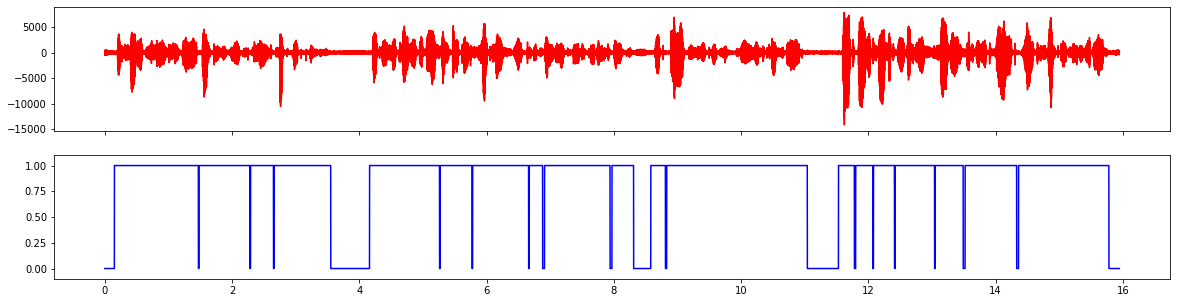

SPEAKER 1034 - PANEL 1
  data/01_raw/vad_data/1034-121119-0005.wav
  data/01_raw/vad_data/1034-121119-0005.json


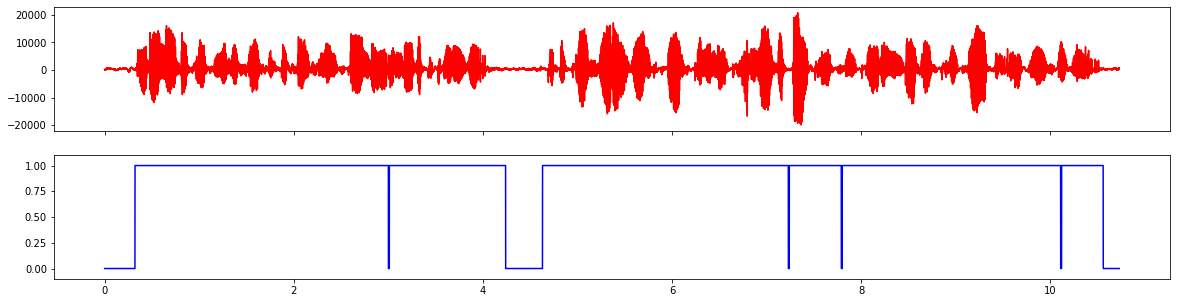

SPEAKER 1040 - PANEL 2
  data/01_raw/vad_data/1040-133433-0001.wav
  data/01_raw/vad_data/1040-133433-0001.json


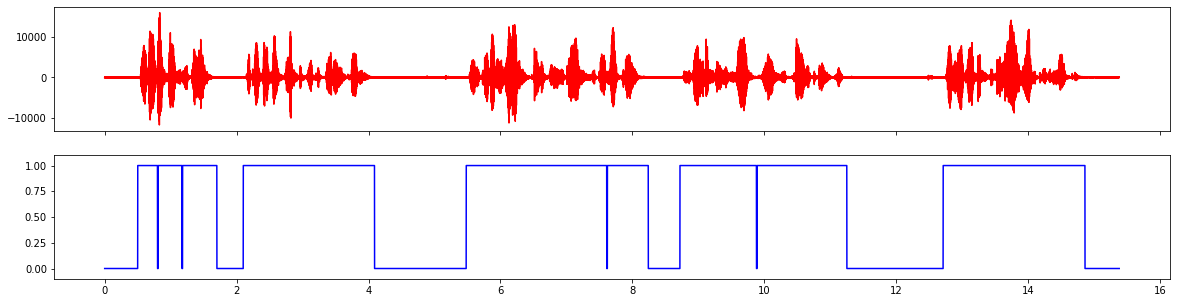

SPEAKER 1069 - PANEL 3
  data/01_raw/vad_data/1069-133699-0000.wav
  data/01_raw/vad_data/1069-133699-0000.json


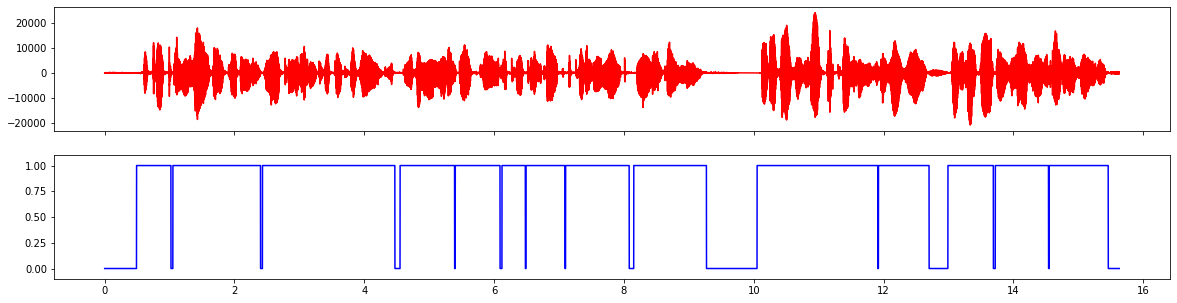

SPEAKER 1081 - PANEL 4
  data/01_raw/vad_data/1081-125237-0007.wav
  data/01_raw/vad_data/1081-125237-0007.json


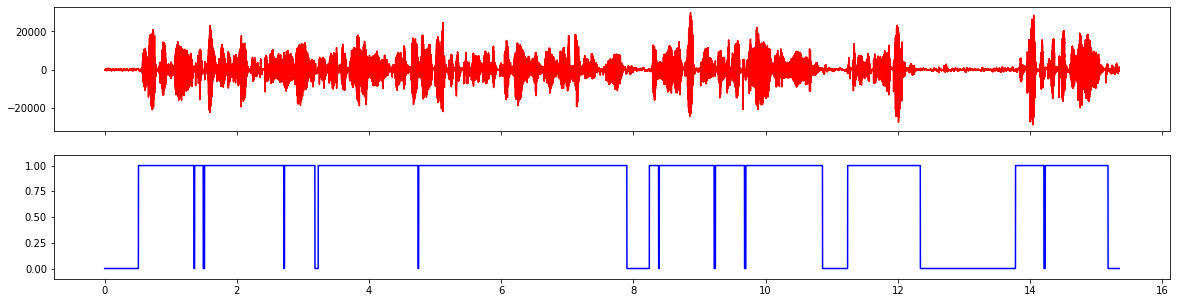

SPEAKER 1088 - PANEL 5
  data/01_raw/vad_data/1088-129236-0003.wav
  data/01_raw/vad_data/1088-129236-0003.json


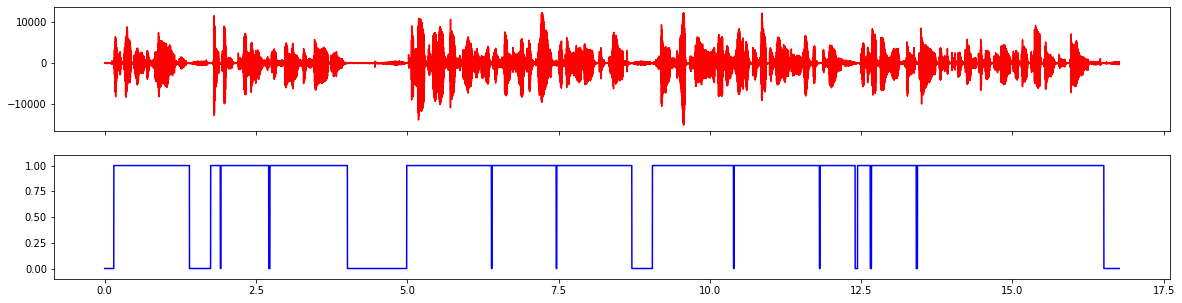

SPEAKER 1098 - PANEL 6
  data/01_raw/vad_data/1098-133695-0001.wav
  data/01_raw/vad_data/1098-133695-0001.json


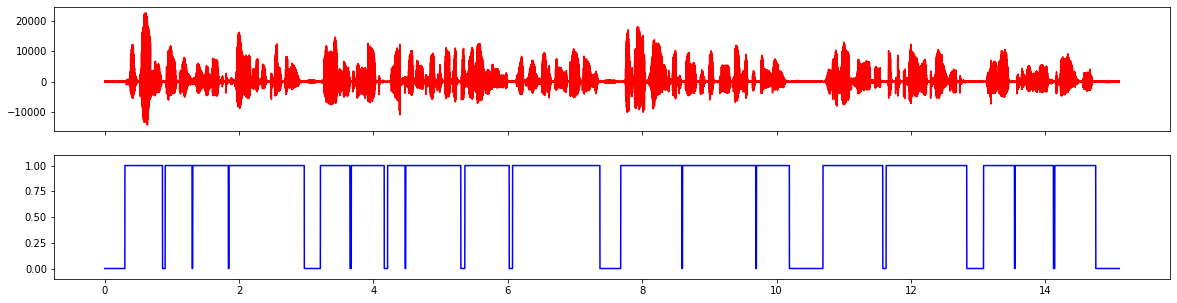

SPEAKER 1116 - PANEL 7
  data/01_raw/vad_data/1116-132847-0003.wav
  data/01_raw/vad_data/1116-132847-0003.json


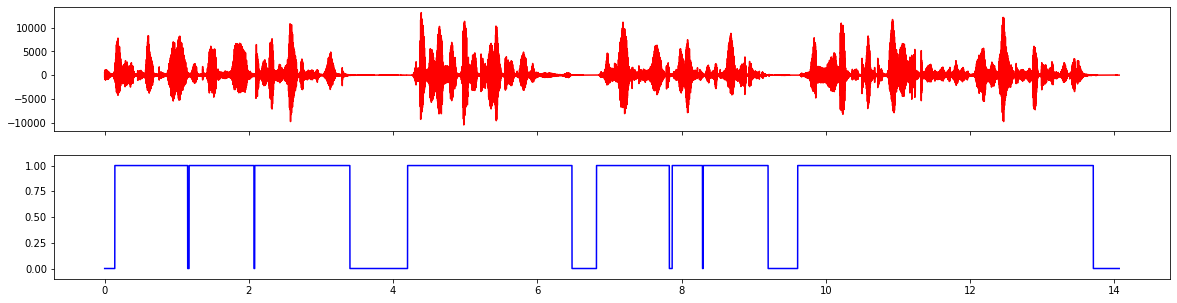

SPEAKER 118 - PANEL 8
  data/01_raw/vad_data/118-121721-0005.wav
  data/01_raw/vad_data/118-121721-0005.json


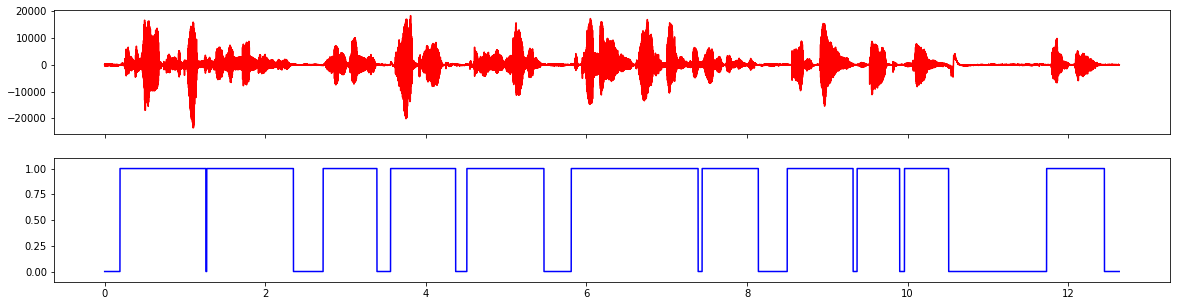

SPEAKER 1183 - PANEL 9
  data/01_raw/vad_data/1183-124566-0000.wav
  data/01_raw/vad_data/1183-124566-0000.json


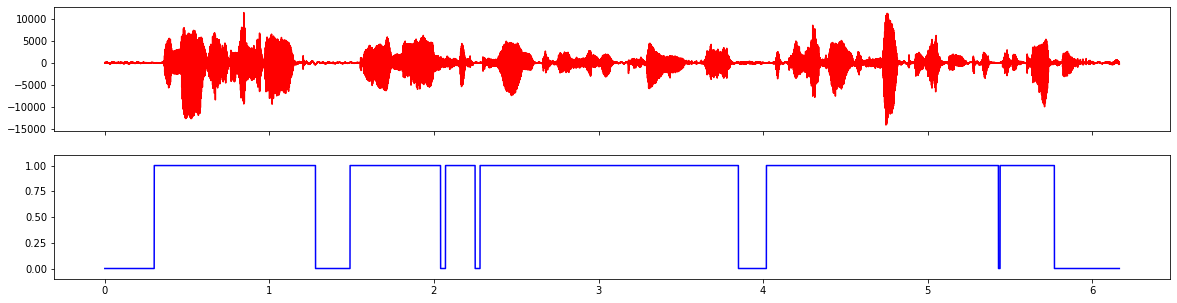

SPEAKER 1235 - PANEL 10
  data/01_raw/vad_data/1235-135883-0007.wav
  data/01_raw/vad_data/1235-135883-0007.json


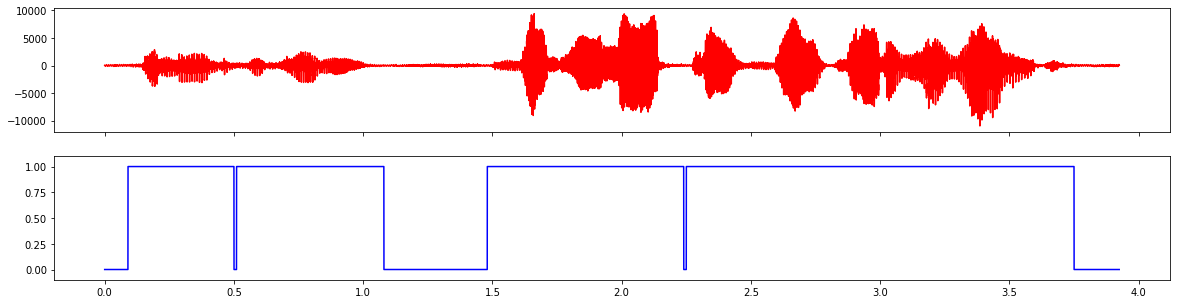

SPEAKER 1246 - PANEL 11
  data/01_raw/vad_data/1246-124548-0000.wav
  data/01_raw/vad_data/1246-124548-0000.json


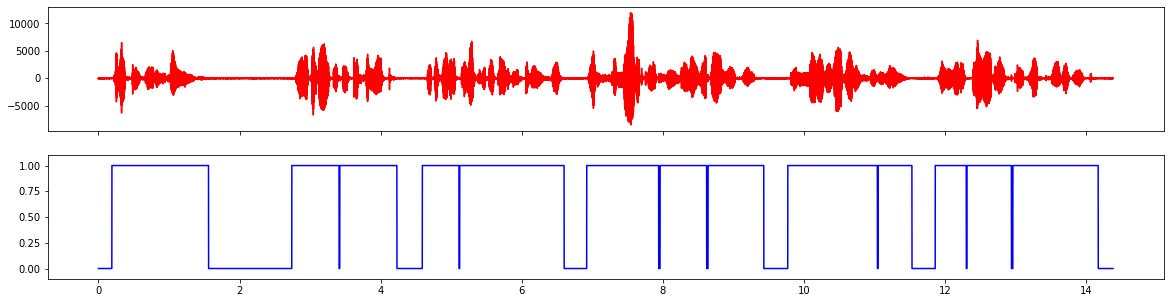

SPEAKER 125 - PANEL 12
  data/01_raw/vad_data/125-121124-0000.wav
  data/01_raw/vad_data/125-121124-0000.json


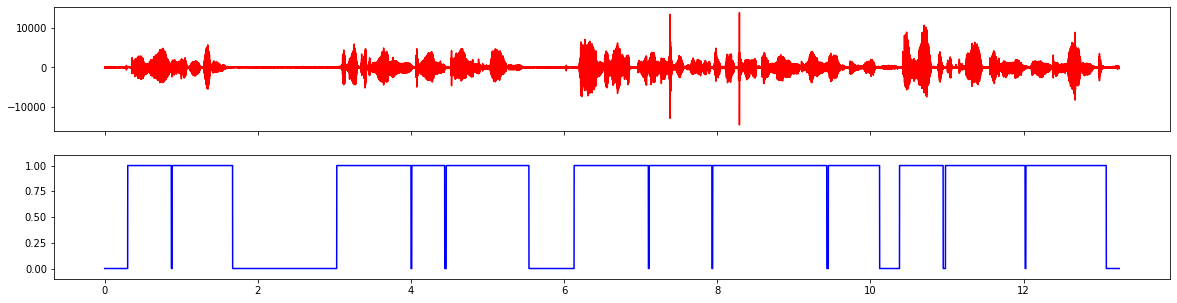

SPEAKER 1263 - PANEL 13
  data/01_raw/vad_data/1263-138246-0000.wav
  data/01_raw/vad_data/1263-138246-0000.json


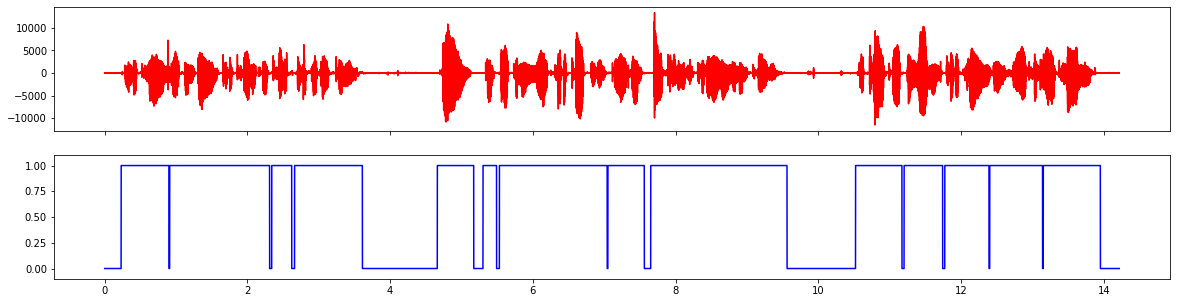

SPEAKER 1334 - PANEL 14
  data/01_raw/vad_data/1334-135589-0011.wav
  data/01_raw/vad_data/1334-135589-0011.json


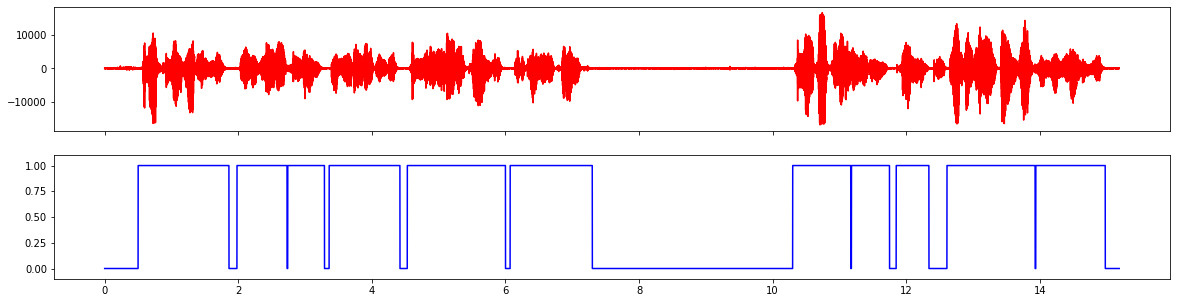

SPEAKER 1355 - PANEL 15
  data/01_raw/vad_data/1355-39947-0014.wav
  data/01_raw/vad_data/1355-39947-0014.json


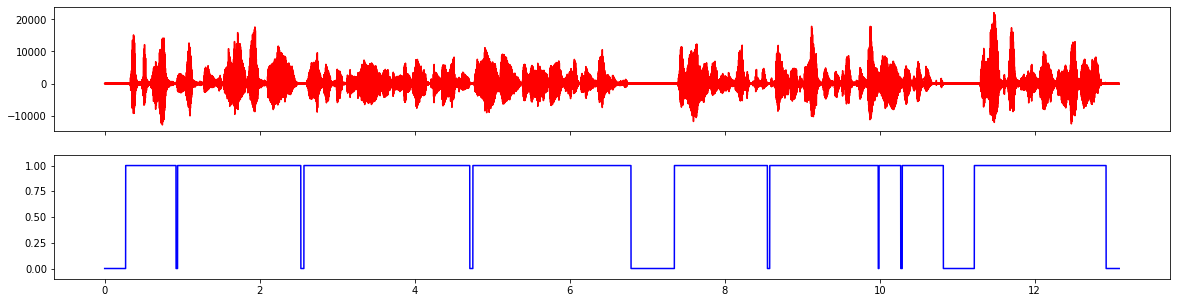

SPEAKER 1363 - PANEL 16
  data/01_raw/vad_data/1363-135842-0000.wav
  data/01_raw/vad_data/1363-135842-0000.json


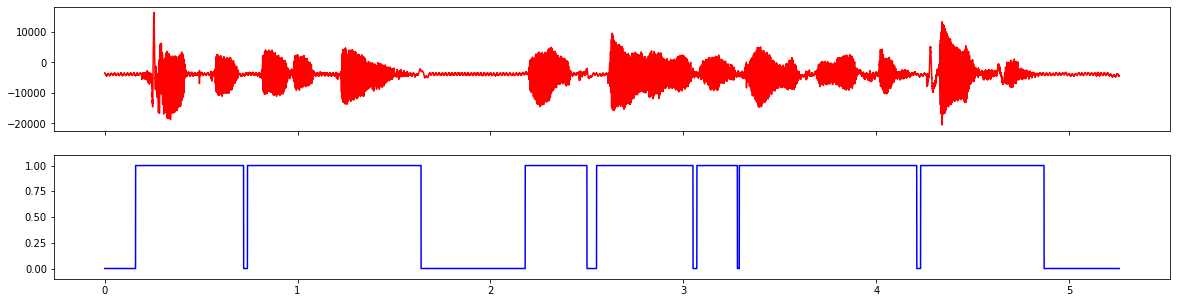

SPEAKER 1447 - PANEL 17
  data/01_raw/vad_data/1447-130550-0000.wav
  data/01_raw/vad_data/1447-130550-0000.json


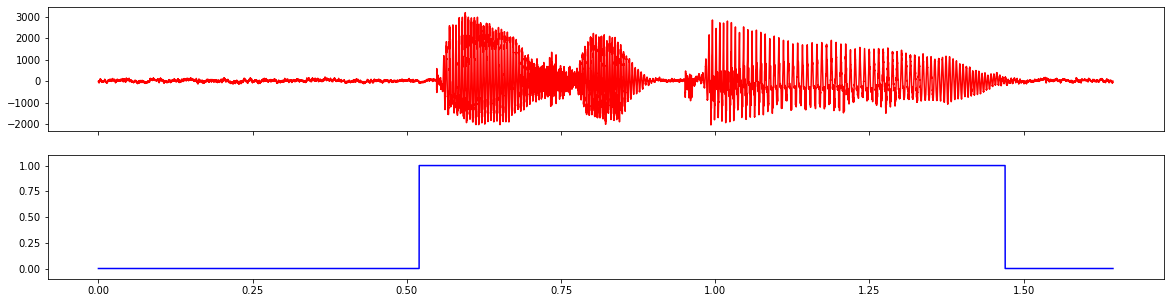

SPEAKER 1455 - PANEL 18
  data/01_raw/vad_data/1455-134435-0007.wav
  data/01_raw/vad_data/1455-134435-0007.json


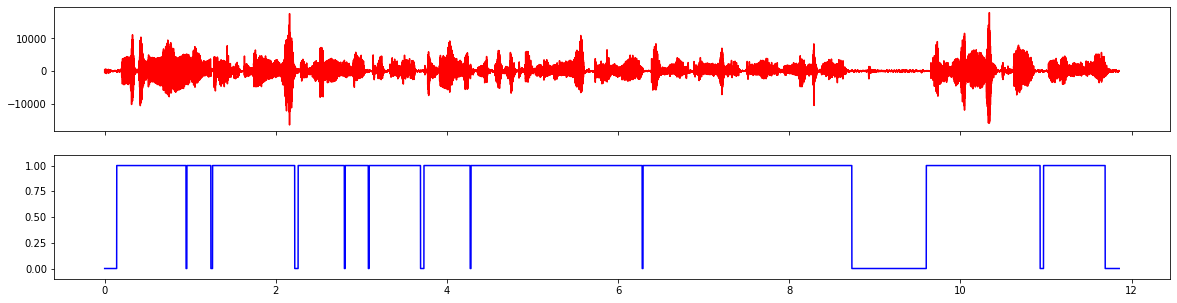

SPEAKER 150 - PANEL 19
  data/01_raw/vad_data/150-126107-0001.wav
  data/01_raw/vad_data/150-126107-0001.json


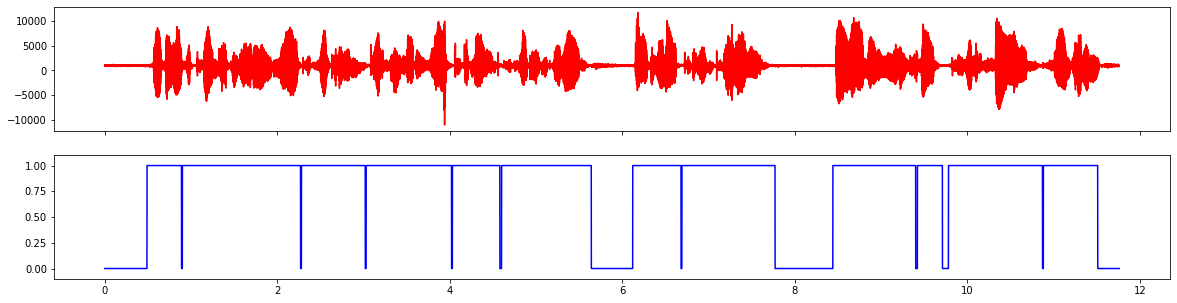

SPEAKER 1502 - PANEL 20
  data/01_raw/vad_data/1502-122615-0007.wav
  data/01_raw/vad_data/1502-122615-0007.json


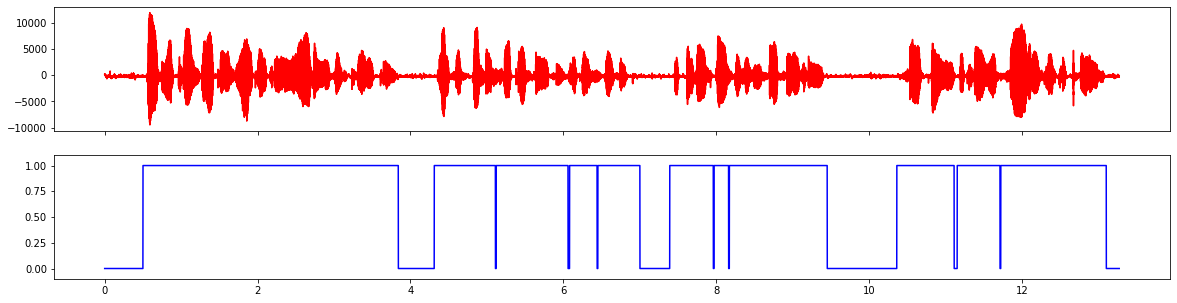

SPEAKER 1553 - PANEL 21
  data/01_raw/vad_data/1553-140047-0002.wav
  data/01_raw/vad_data/1553-140047-0002.json


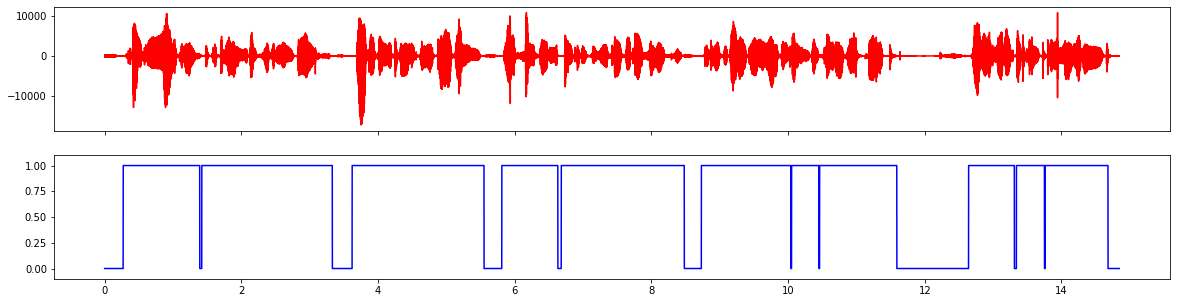

SPEAKER 1578 - PANEL 22
  data/01_raw/vad_data/1578-140045-0000.wav
  data/01_raw/vad_data/1578-140045-0000.json


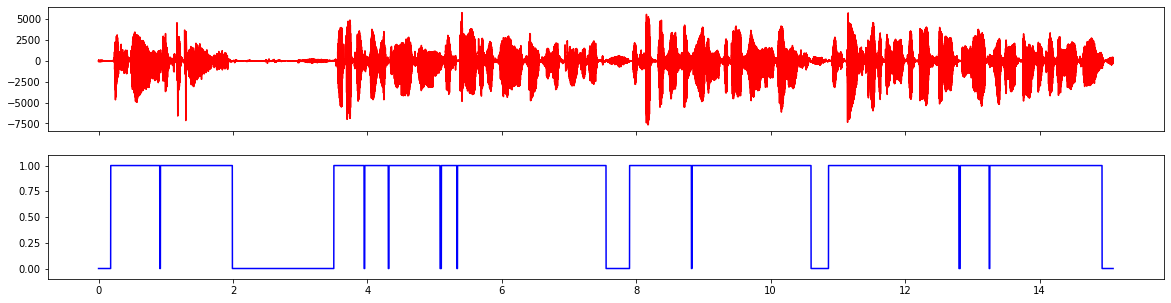

SPEAKER 1594 - PANEL 23
  data/01_raw/vad_data/1594-135914-0004.wav
  data/01_raw/vad_data/1594-135914-0004.json


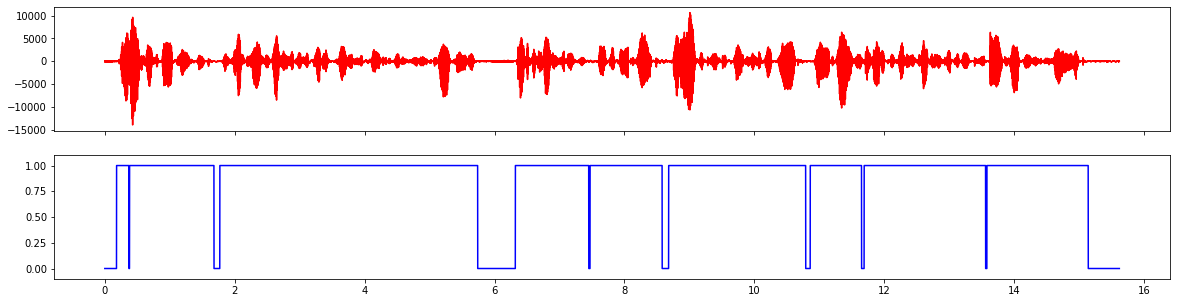

SPEAKER 1624 - PANEL 24
  data/01_raw/vad_data/1624-142933-0003.wav
  data/01_raw/vad_data/1624-142933-0003.json


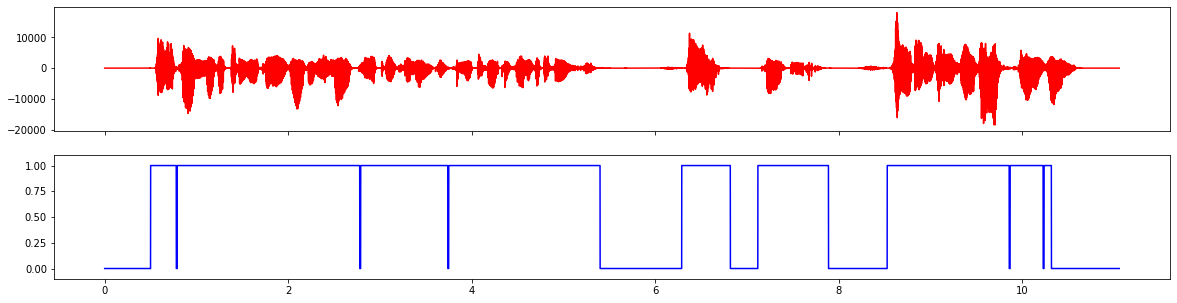

SPEAKER 163 - PANEL 25
  data/01_raw/vad_data/163-121908-0006.wav
  data/01_raw/vad_data/163-121908-0006.json


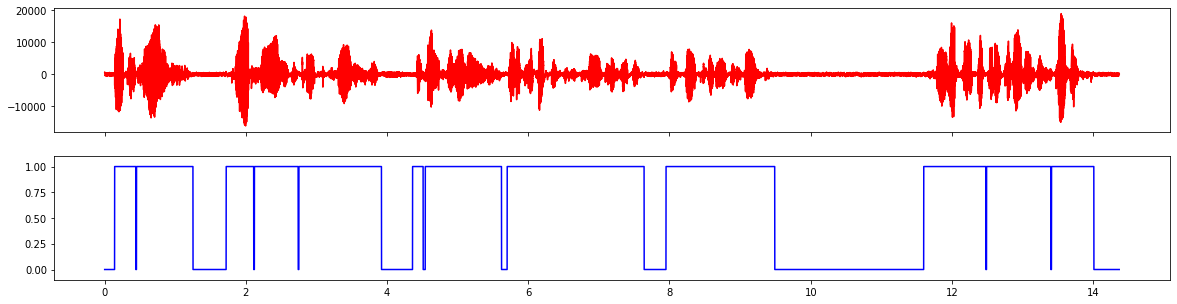

SPEAKER 1723 - PANEL 26
  data/01_raw/vad_data/1723-141149-0005.wav
  data/01_raw/vad_data/1723-141149-0005.json


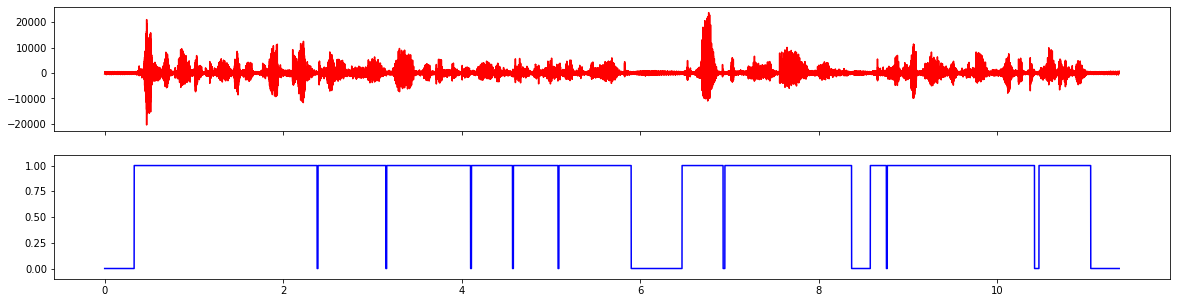

SPEAKER 1737 - PANEL 27
  data/01_raw/vad_data/1737-142396-0000.wav
  data/01_raw/vad_data/1737-142396-0000.json


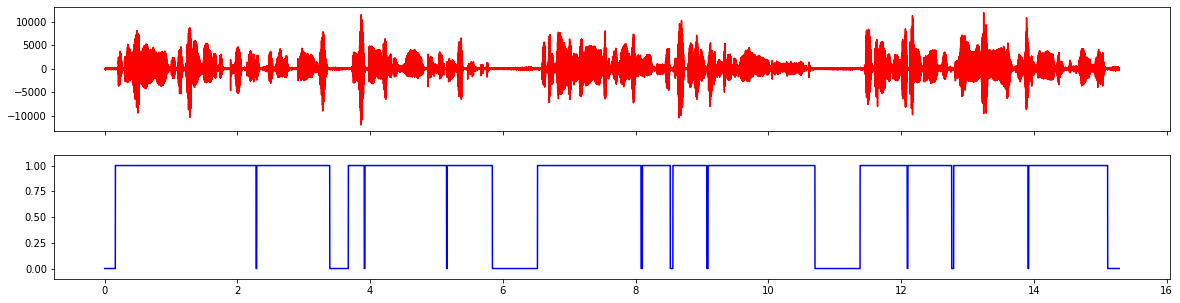

SPEAKER 1743 - PANEL 28
  data/01_raw/vad_data/1743-142912-0002.wav
  data/01_raw/vad_data/1743-142912-0002.json


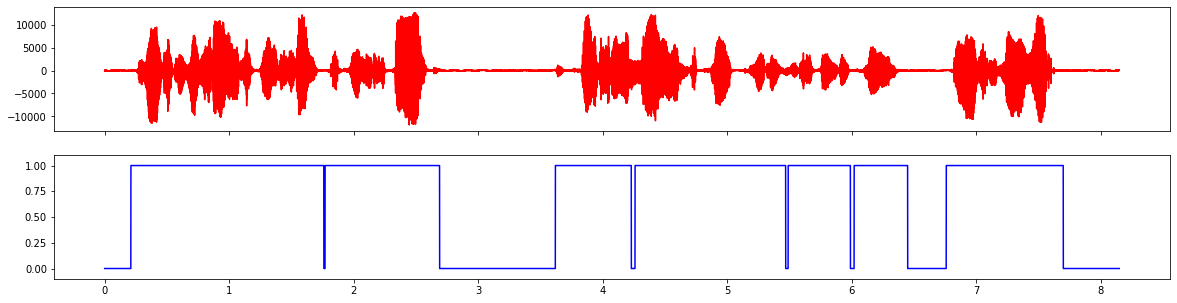

SPEAKER 1841 - PANEL 29
  data/01_raw/vad_data/1841-150351-0013.wav
  data/01_raw/vad_data/1841-150351-0013.json


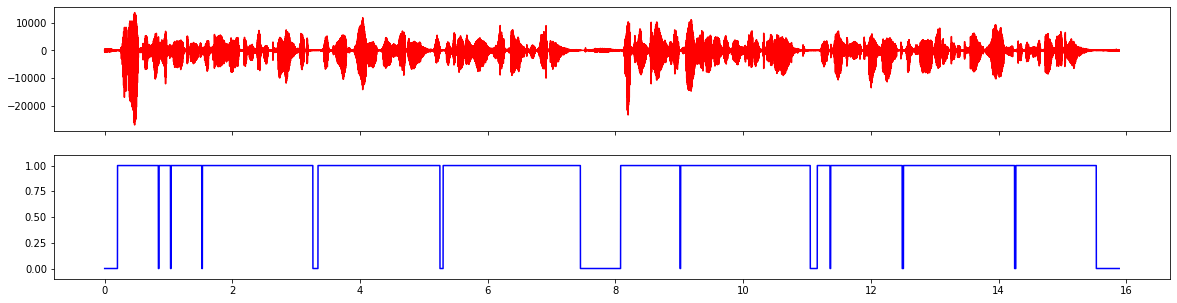

SPEAKER 1867 - PANEL 30
  data/01_raw/vad_data/1867-148436-0001.wav
  data/01_raw/vad_data/1867-148436-0001.json


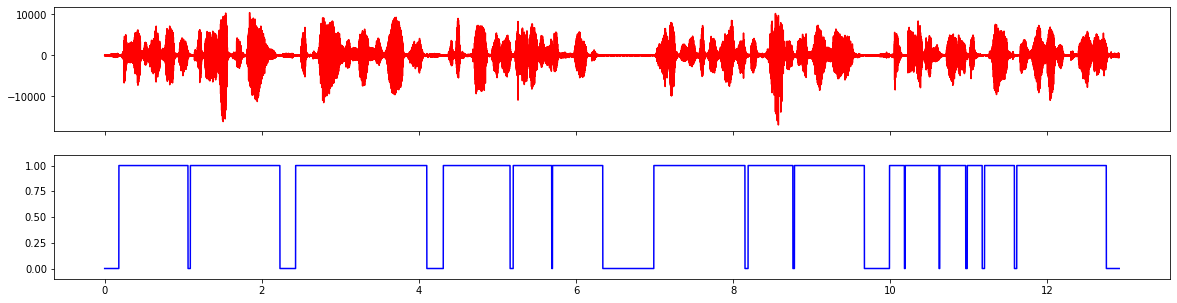

SPEAKER 1898 - PANEL 31
  data/01_raw/vad_data/1898-145702-0007.wav
  data/01_raw/vad_data/1898-145702-0007.json


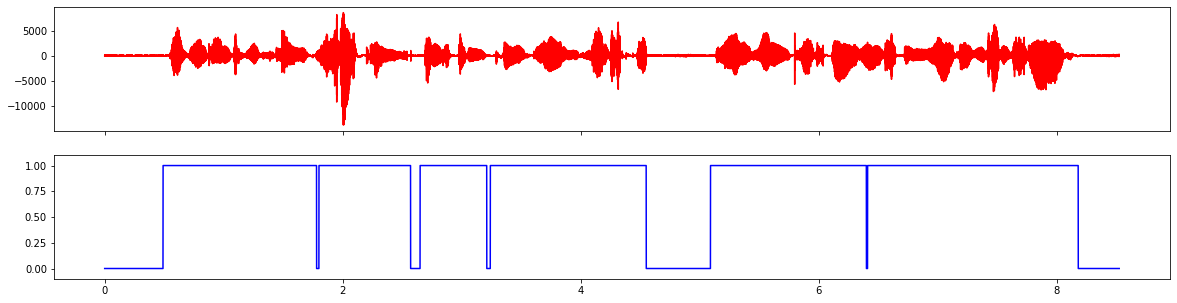

SPEAKER 19 - PANEL 32
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


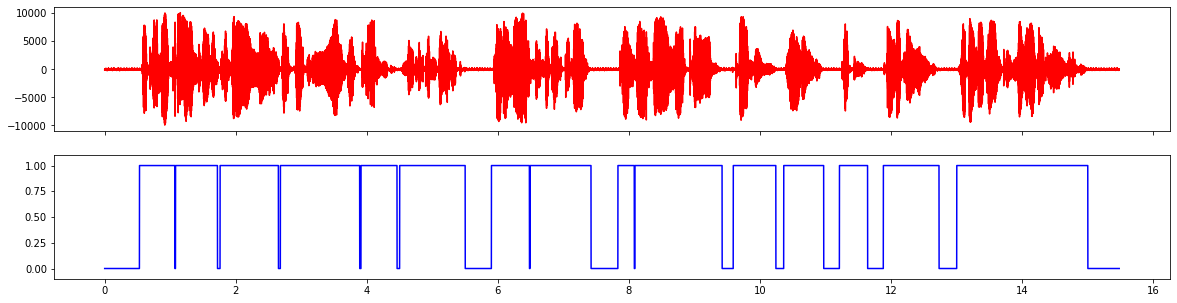

SPEAKER 1926 - PANEL 33
  data/01_raw/vad_data/1926-143879-0002.wav
  data/01_raw/vad_data/1926-143879-0002.json


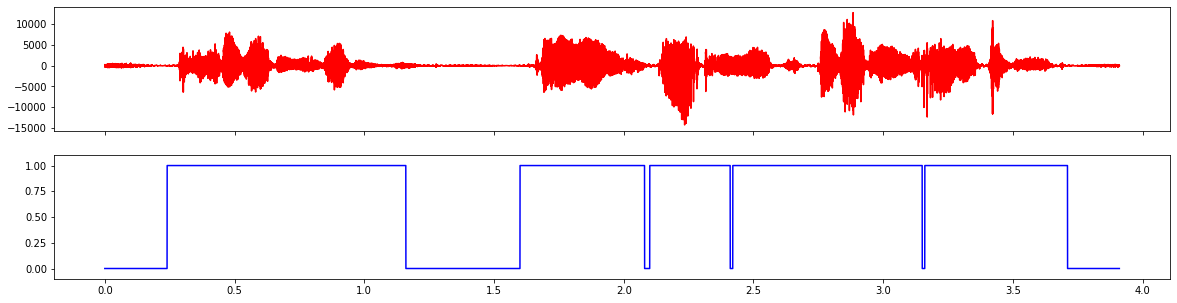

18.41 sec


In [245]:
# show an example per speaker
_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)
    
# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " ,audio_files[exple])
    print(" " ,label_files[exple])    
    audio = read_X(audio_files[exple])
    label = load_Y(label_files[exple])
    synced = sync_audio_and_labels(audio, label)
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )
if VERBOSE: 
    print(np.round(time.time()-tic,2), "sec")